In [1]:
import pandas as pd
pd.set_option('display.max_columns',None)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scorecardpy as sc

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import joblib
import json

from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import ClassificationReport
from sklearn.metrics import balanced_accuracy_score,precision_score,recall_score,f1_score,roc_auc_score

import warnings
warnings.filterwarnings("ignore")

C:\Users\PC\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
#---- read dataset -----
df = pd.read_excel('CreditRiskDataset.xlsx')

In [3]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


# Data Cleaning

<Axes: >

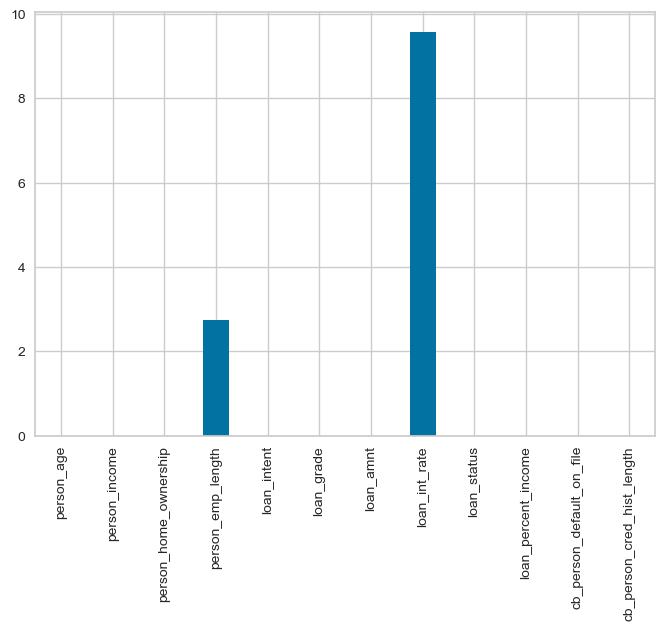

In [4]:
#--- check data nulls ----
(df.isna().sum()/len(df)*100).plot(kind='bar')

Data memiliki missing values 10% pada loan_int_rate dan 3% pada person_home_ownership

<Axes: xlabel='person_age'>

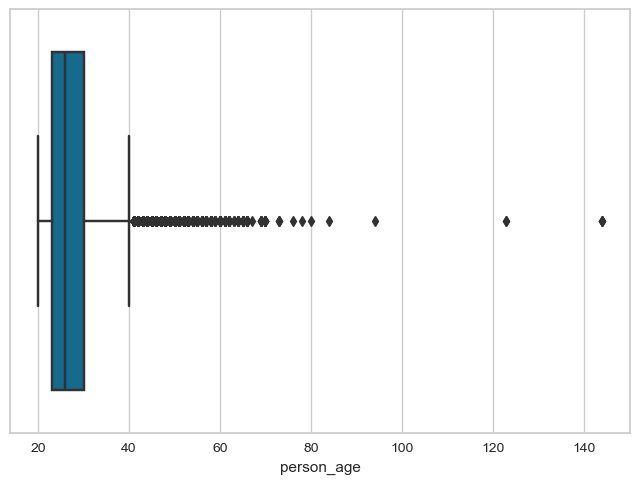

In [5]:
#--- apakah ada outliers pada age ? -----
sns.boxplot(data=df,x='person_age')

Jika mengacu pada usia pekerja seharusnya usia orang yang dapat mendapatkan pinjaman tidak boleh kurang dari 18 tahun dan lebih dari 65 tahun. sehingga melebihi angka tersebut maka akan dianggap sebagai outliers.

In [6]:
in_data = (df['person_age']>=18) & (df['person_age']<=65)

print(f'Sebelum outlier dibuang {df.shape[0]}')

df = df[in_data]

print(f'setelah outlier dibuang {df.shape[0]}')

Sebelum outlier dibuang 32581
setelah outlier dibuang 32546


<Axes: xlabel='person_emp_length'>

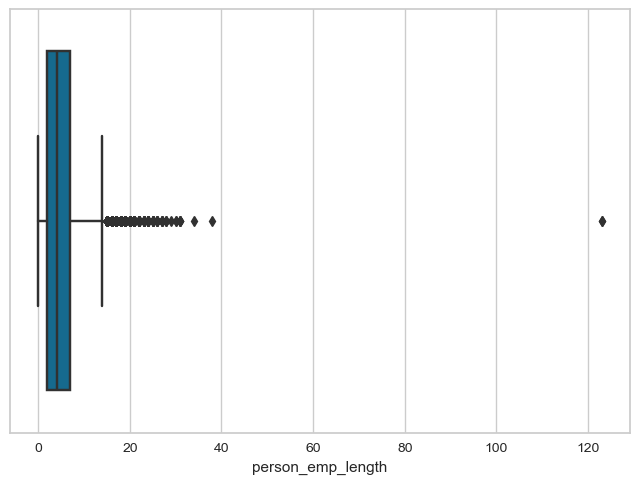

In [7]:
sns.boxplot(data=df,x='person_emp_length')

In [8]:
imputasi = df[(df["person_emp_length"]<=47)&(df["person_age"]>=21)&(df["person_age"]<=22)]["person_emp_length"].median()
df.loc[(df["person_emp_length"]>7)&(df["person_age"]>=21)&(df["person_age"]<=22),'person_emp_length'] = imputasi

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32546 entries, 0 to 32579
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32546 non-null  int64  
 1   person_income               32546 non-null  int64  
 2   person_home_ownership       32546 non-null  object 
 3   person_emp_length           31652 non-null  float64
 4   loan_intent                 32546 non-null  object 
 5   loan_grade                  32546 non-null  object 
 6   loan_amnt                   32546 non-null  int64  
 7   loan_int_rate               29435 non-null  float64
 8   loan_status                 32546 non-null  int64  
 9   loan_percent_income         32546 non-null  float64
 10  cb_person_default_on_file   32546 non-null  object 
 11  cb_person_cred_hist_length  32546 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.2+ MB


In [10]:
df[df['person_emp_length'].isna()]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
105,22,12600,MORTGAGE,NaN,PERSONAL,A,2000,5.42,1,0.16,N,4
222,24,185000,MORTGAGE,NaN,EDUCATION,B,35000,12.42,0,0.19,N,2
379,24,16800,MORTGAGE,NaN,DEBTCONSOLIDATION,A,3900,NaN,1,0.23,N,3
407,25,52000,RENT,NaN,PERSONAL,B,24000,10.74,1,0.46,N,2
408,22,17352,MORTGAGE,NaN,EDUCATION,C,2250,15.27,0,0.13,Y,3
...,...,...,...,...,...,...,...,...,...,...,...,...
32274,38,30132,RENT,NaN,MEDICAL,C,3000,13.85,1,0.10,Y,14
32285,38,12000,OWN,NaN,EDUCATION,A,4800,7.29,1,0.40,N,12
32328,51,18408,RENT,NaN,PERSONAL,C,1000,14.65,1,0.05,Y,20
32453,56,32400,RENT,NaN,MEDICAL,A,8575,7.51,0,0.26,N,18


In [11]:
df[df['person_emp_length']<4]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
5,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,N,2
11,21,10000,OWN,2.0,HOMEIMPROVEMENT,A,4500,8.63,1,0.45,N,2
12,23,95000,RENT,2.0,VENTURE,A,35000,7.90,1,0.37,N,2
14,23,115000,RENT,2.0,EDUCATION,A,35000,7.90,0,0.30,N,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32572,52,52000,OWN,0.0,PERSONAL,A,9600,8.49,0,0.18,N,22
32573,56,90000,MORTGAGE,0.0,PERSONAL,A,7200,6.17,0,0.08,N,19
32575,52,64500,RENT,0.0,EDUCATION,B,5000,11.26,0,0.08,N,20
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30


In [12]:
age_bins = [20, 25, 30, 35, 40, 45, 50, 55, np.inf]
age_labels = ['20-25', '26-30', '31-35', '36-40', '41-45', '46-50', '51-55', '56+']

df['person_age_bin'] = pd.cut(df['person_age'].fillna('missing'), bins=age_bins, labels=age_labels, right=False)

In [13]:
# Fill missing values in loan_int_rate with a placeholder value
df['loan_int_rate'] = df['loan_int_rate'].fillna(-1)  # Use a different placeholder value if needed

# Define custom bins and labels for loan_int_rate
int_rate_bins = [-2, 10, 15, 20, np.inf]  # Adjusted to include the placeholder value
int_rate_labels = ['missing', '5.42-10', '10-15', '15-20']

# Binning for loan_int_rate
df['loan_int_rate_bin'] = pd.cut(df['loan_int_rate'], bins=int_rate_bins, labels=int_rate_labels, right=False)

In [14]:
# validation percent loan amount ot income
df['validasi_percent_loan_amount_to_income'] = round((df['loan_amnt']) / df['person_income'],2)

df['flag'] = np.where(
    df['loan_percent_income']==df["validasi_percent_loan_amount_to_income"],1,0
)

df[df['flag']==0][["loan_amnt","person_income","loan_percent_income","validasi_percent_loan_amount_to_income"]]

,loan_amnt,person_income,loan_percent_income,validasi_percent_loan_amount_to_income
4,35000,54400,0.55,0.64
17,35000,92111,0.32,0.38
36,30000,48000,0.63,0.62
40,30000,62050,0.41,0.48
48,30000,66300,0.38,0.45
...,...,...,...,...
32447,8000,64000,0.13,0.12
32480,25000,62050,0.34,0.40
32485,3000,24000,0.13,0.12
32555,18000,80000,0.23,0.22


In [15]:
df['loan_percent_income'] = df["validasi_percent_loan_amount_to_income"]
df = df.drop(["validasi_percent_loan_amount_to_income","flag"],axis=1)

We found that percent loan to income is incorrect so we will replace the value loan_percent_income

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32546 entries, 0 to 32579
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   person_age                  32546 non-null  int64   
 1   person_income               32546 non-null  int64   
 2   person_home_ownership       32546 non-null  object  
 3   person_emp_length           31652 non-null  float64 
 4   loan_intent                 32546 non-null  object  
 5   loan_grade                  32546 non-null  object  
 6   loan_amnt                   32546 non-null  int64   
 7   loan_int_rate               32546 non-null  float64 
 8   loan_status                 32546 non-null  int64   
 9   loan_percent_income         32546 non-null  float64 
 10  cb_person_default_on_file   32546 non-null  object  
 11  cb_person_cred_hist_length  32546 non-null  int64   
 12  person_age_bin              32546 non-null  category
 13  loan_int_rate_bin    

# EDA

In [17]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,person_age_bin,loan_int_rate_bin
0,22,59000,RENT,4.0,PERSONAL,D,35000,16.02,1,0.59,Y,3,20-25,10-15
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2,20-25,5.42-10
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3,26-30,5.42-10
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2,20-25,10-15
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.64,Y,4,20-25,5.42-10


In [18]:
df_train,df_test = train_test_split(df,
                                    stratify=df['loan_status'],
                                                 test_size=0.3,
                                                 random_state=32)

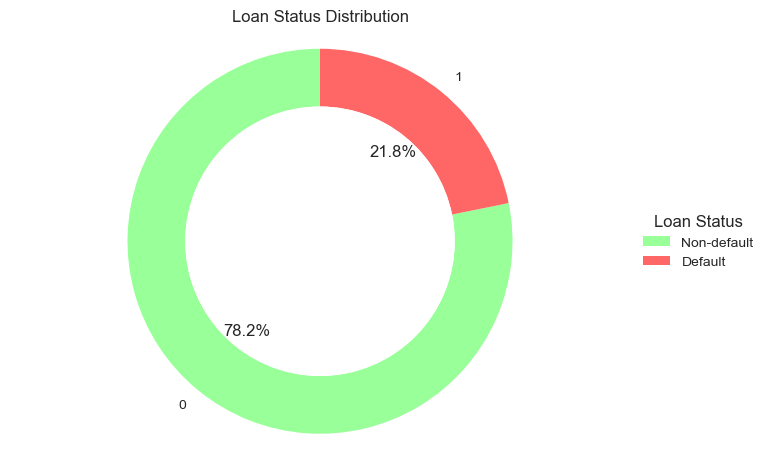

In [19]:
labels = df_train['loan_status'].value_counts().index
sizes = df_train['loan_status'].value_counts().values

colors = ['#99ff99','#ff6666']

fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.3), colors=colors)

centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

ax.axis('equal')  

plt.title('Loan Status Distribution')

ax.legend(wedges, ["Non-default", "Default"], title="Loan Status", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.savefig('donut_chart.png', transparent=True, facecolor='none')

plt.show()

In [33]:
df["cb_person_default_on_file"].unique()

array(['Y', 'N'], dtype=object)

In [20]:
global_mean =round(df_train['loan_status'].mean()*100,0)

print(f'Percentage Nasabah yang gagal bayar sebesar {global_mean}%')

Percentage Nasabah yang gagal bayar sebesar 22.0%


,total_nasabah,total_nasabah_gagal_bayar,percent_gagal_bayar,risk
person_home_ownership,,,,
RENT,11514,3640,31.61,9.61
OTHER,78,22,28.21,6.21
MORTGAGE,9405,1178,12.53,-9.47
OWN,1785,132,7.39,-14.61


<Figure size 1000x600 with 0 Axes>

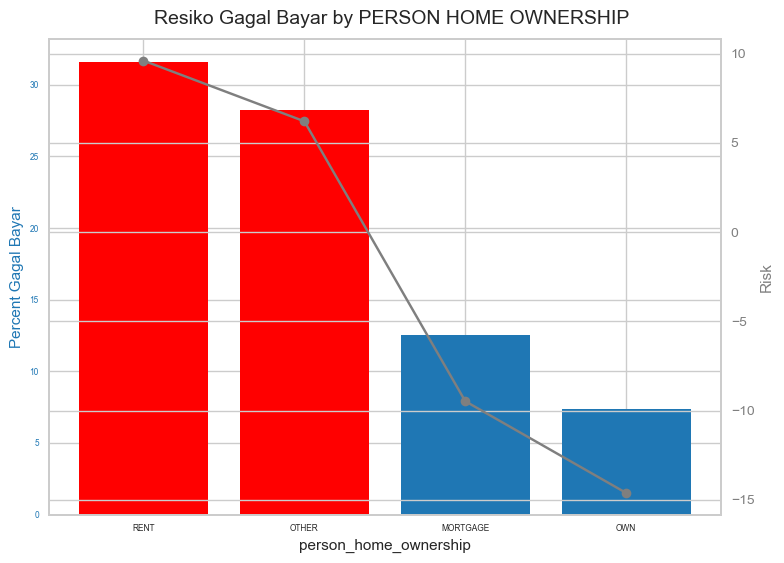

,total_nasabah,total_nasabah_gagal_bayar,percent_gagal_bayar,risk
loan_intent,,,,
DEBTCONSOLIDATION,3701,1041,28.13,6.13
MEDICAL,4251,1171,27.55,5.55
HOMEIMPROVEMENT,2482,637,25.66,3.66
PERSONAL,3849,769,19.98,-2.02
EDUCATION,4505,769,17.07,-4.93
VENTURE,3994,585,14.65,-7.35


<Figure size 1000x600 with 0 Axes>

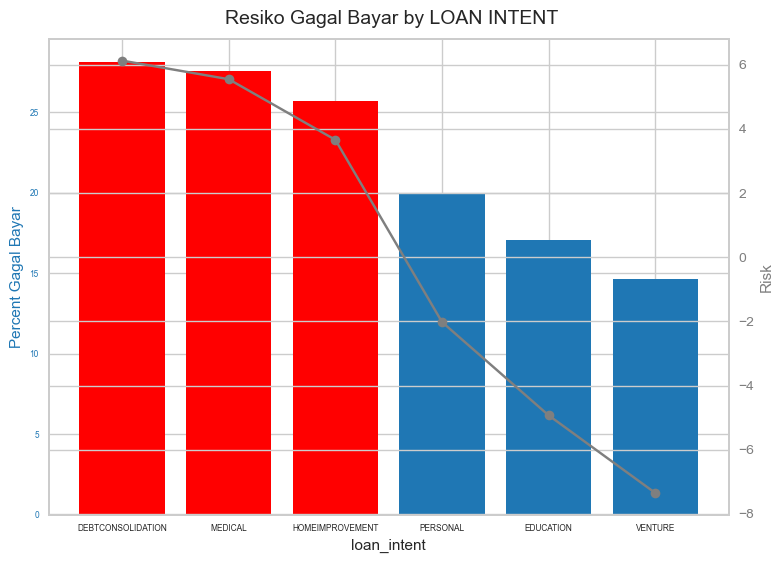

,total_nasabah,total_nasabah_gagal_bayar,percent_gagal_bayar,risk
loan_grade,,,,
G,51,50,98.04,76.04
F,169,121,71.60,49.60
E,687,439,63.90,41.90
D,2514,1492,59.35,37.35
C,4500,938,20.84,-1.16
B,7314,1187,16.23,-5.77
A,7547,745,9.87,-12.13


<Figure size 1000x600 with 0 Axes>

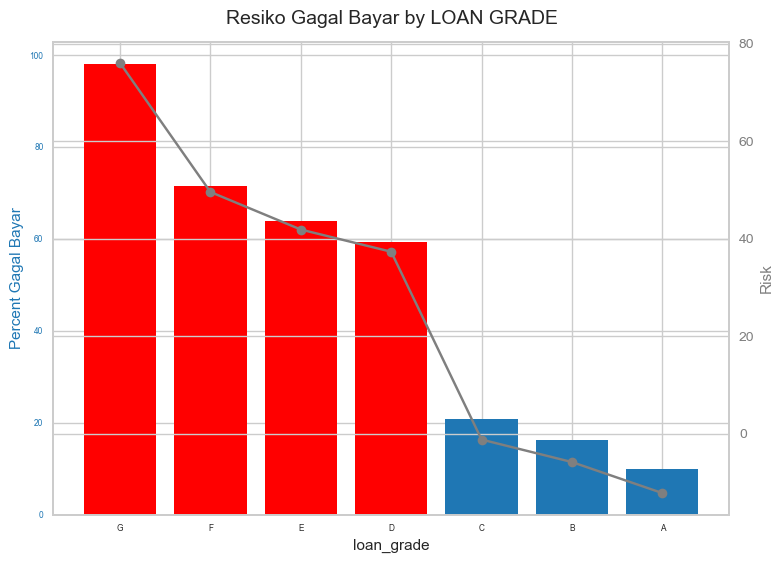

,total_nasabah,total_nasabah_gagal_bayar,percent_gagal_bayar,risk
cb_person_default_on_file,,,,
Y,4039,1520,37.63,15.63
N,18743,3452,18.42,-3.58


<Figure size 1000x600 with 0 Axes>

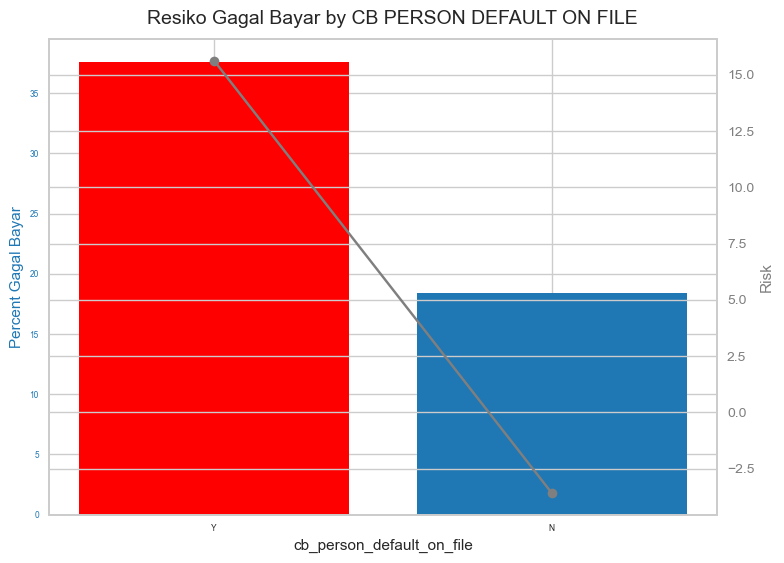

In [21]:
def plot_risk_for_categorical_column(df, categorical_column, global_mean):
    temp = df.groupby(categorical_column).agg({
        "loan_status": [len, 'sum', 'mean']
    })

    temp.columns = ['_'.join(x) for x in temp.columns]
    temp = temp.rename(columns={
        "loan_status_len": "total_nasabah",
        "loan_status_sum": "total_nasabah_gagal_bayar",
        "loan_status_mean": "percent_gagal_bayar"
    })

    temp['percent_gagal_bayar'] = round(temp['percent_gagal_bayar'] * 100, 2)

    temp['risk'] = temp['percent_gagal_bayar'] - global_mean

    temp = temp.sort_values('risk', ascending=False)
    
    display(temp)
   
    plt.figure(figsize=(10, 6))
    fig, ax1 = plt.subplots()

    ax1.set_xlabel(categorical_column)
    ax1.set_ylabel('Percent Gagal Bayar', color='tab:blue')
    ax1.bar(temp.index, temp.percent_gagal_bayar, color=['red' if x > 21.8 else 'tab:blue' for x in temp['percent_gagal_bayar']])
    ax1.tick_params(axis='y', labelcolor='tab:blue')

   
    ax2 = ax1.twinx()

   
    color = 'tab:red'
    ax2.set_ylabel('Risk', color='tab:grey')
    ax2.plot(temp.index, temp.risk, color='tab:grey', marker='o')
    ax2.tick_params(axis='y', labelcolor='tab:grey')

    ax1.tick_params(labelsize=6)
    
    fig.tight_layout()

   
    fig.suptitle(f'Resiko Gagal Bayar by {categorical_column.replace("_"," ").upper()}', y=1.02, fontsize=14)

   
    plt.savefig(f'{categorical_column}_risk_plot.png', transparent=True, facecolor='none')

    
    plt.show()


for cat in df_train.select_dtypes(include='O').columns:
    plot_risk_for_categorical_column(df_train, cat, global_mean)

Text(0.5, 1.0, 'Loan Amount By Loan Grade')

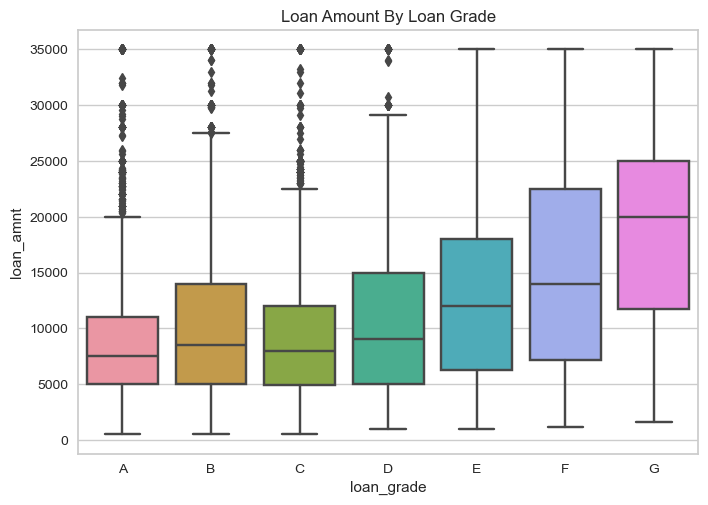

In [22]:
sns.boxplot(data=df_train.sort_values('loan_grade',ascending=True),x='loan_grade',y='loan_amnt').set_title('Loan Amount By Loan Grade')

Text(0.5, 1.0, 'Person Income By Loan Grade')

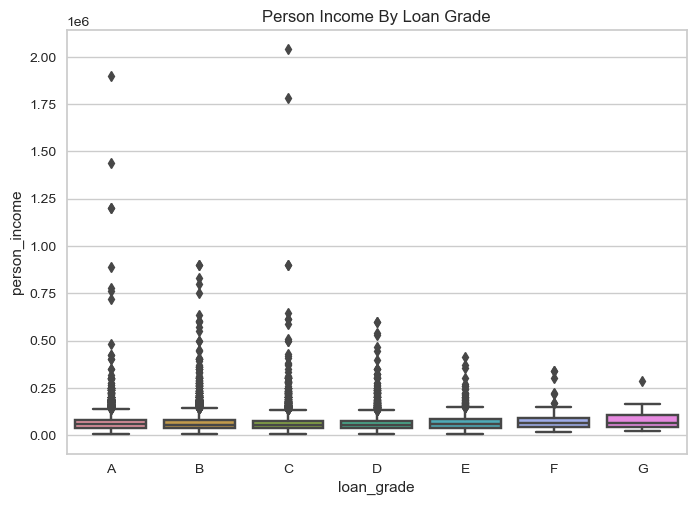

In [23]:
sns.boxplot(data=df_train.sort_values('loan_grade',ascending=True),x='loan_grade',y='person_income').set_title('Person Income By Loan Grade')

Text(0.5, 1.0, 'Person Income By Loan Grade')

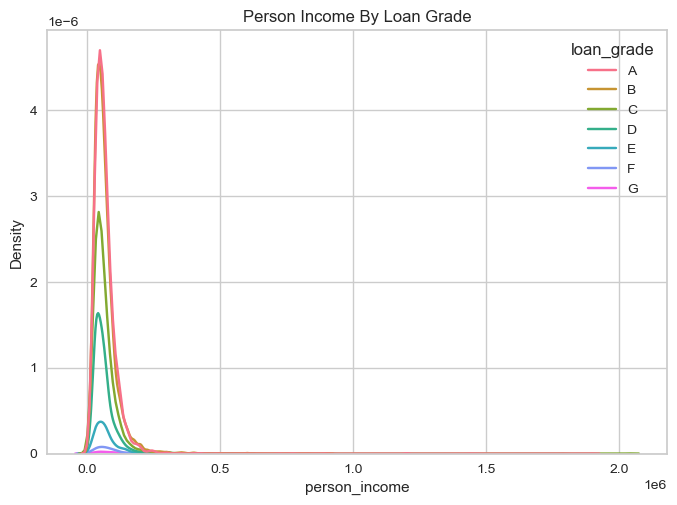

In [24]:
sns.kdeplot(data=df_train.sort_values('loan_grade',ascending=True),x='person_income',hue='loan_grade').set_title('Person Income By Loan Grade')

# Preprocessing Data

In [25]:
df["cb_person_cred_hist_length"].max()

30

In [26]:
features = ['person_income', 'person_home_ownership', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income','cb_person_default_on_file', 'cb_person_cred_hist_length']

target = 'loan_status'


df_train = df_train[features+[target]]
df_test = df_test[features+[target]]

In [27]:
# feature selection
dt_s = sc.var_filter(df_train, y=target)

#update feature on data test
df_test = df_test[dt_s.columns]

[INFO] filtering variables ...


In [28]:
bins = sc.woebin(dt_s, y=target)

[INFO] creating woe binning ...


{'cb_person_default_on_file': <Figure size 800x550 with 2 Axes>,
 'loan_amnt': <Figure size 800x550 with 2 Axes>,
 'loan_percent_income': <Figure size 800x550 with 2 Axes>,
 'person_home_ownership': <Figure size 800x550 with 2 Axes>,
 'loan_intent': <Figure size 800x550 with 2 Axes>,
 'loan_grade': <Figure size 800x550 with 2 Axes>,
 'loan_int_rate': <Figure size 800x550 with 2 Axes>,
 'person_income': <Figure size 800x550 with 2 Axes>}

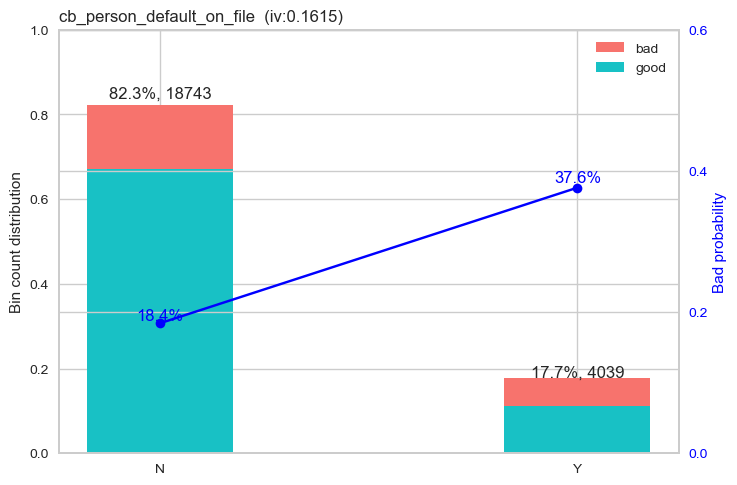

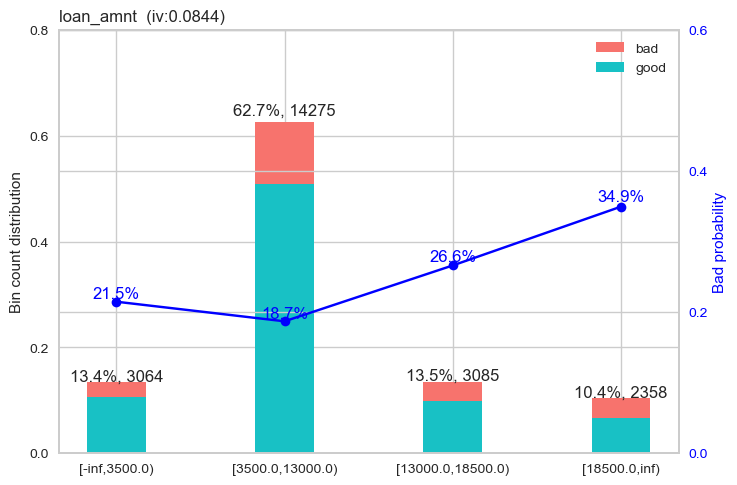

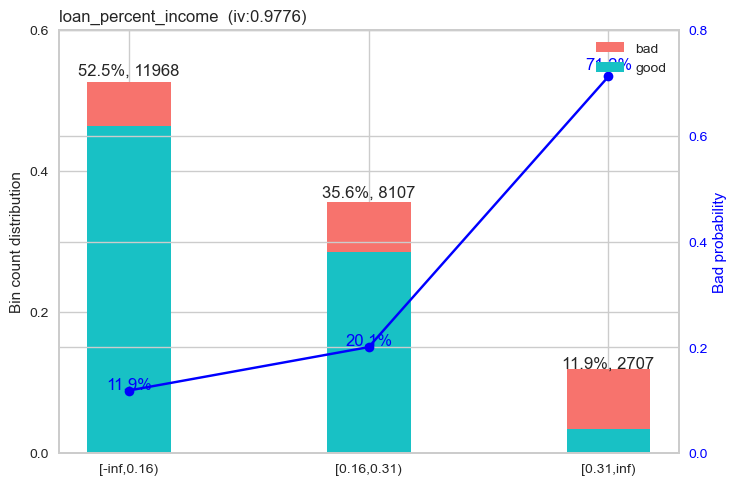

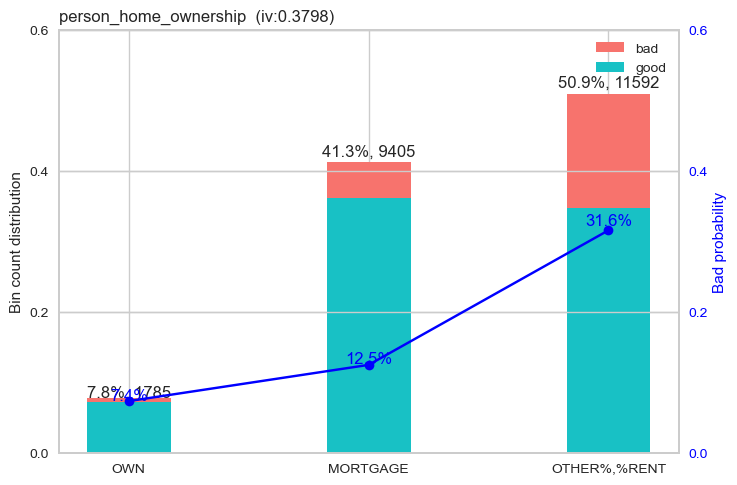

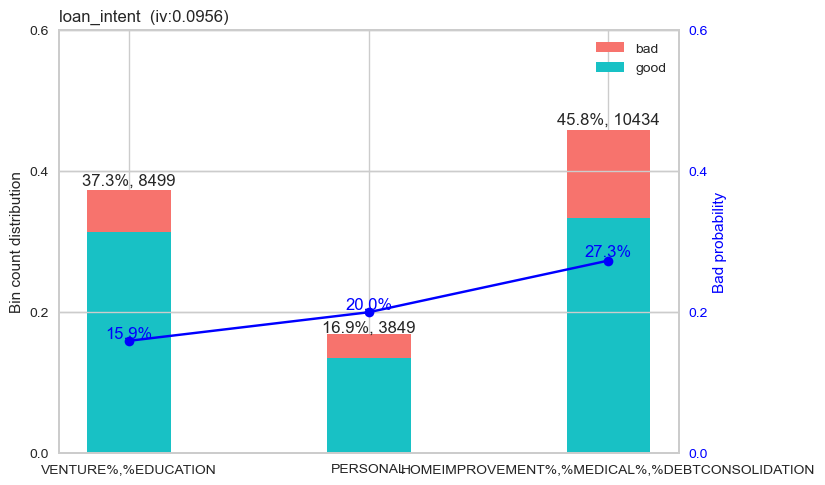

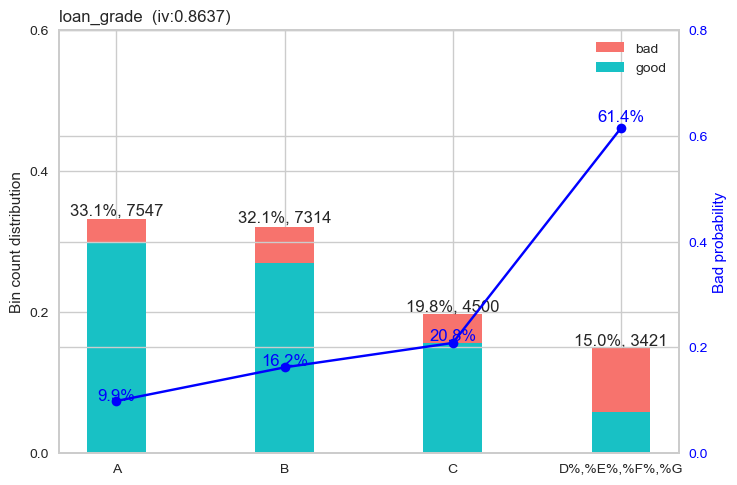

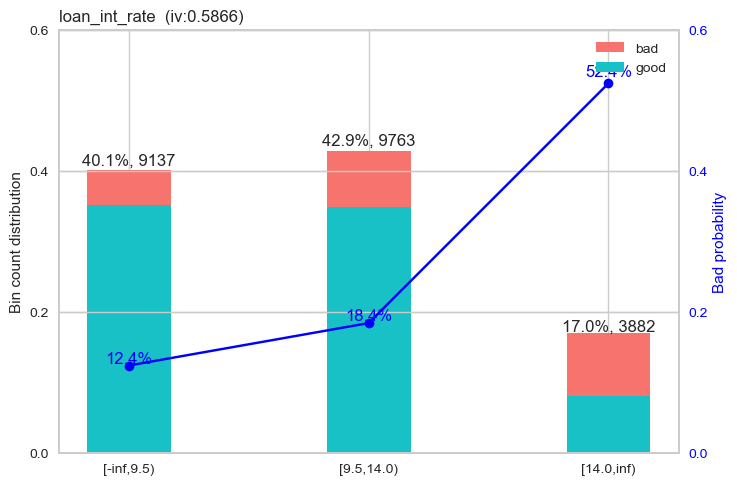

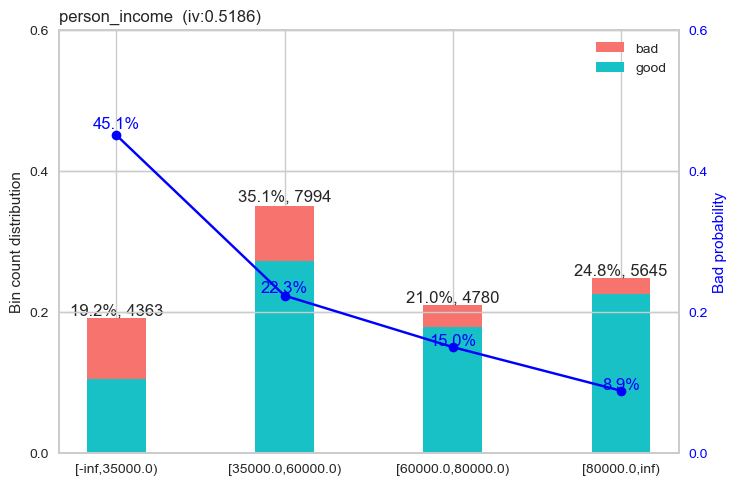

In [29]:
sc.woebin_plot(bins)

In [30]:
train_woe = sc.woebin_ply(dt_s, bins)
test_woe = sc.woebin_ply(df_test, bins)

[INFO] converting into woe values ...
[INFO] converting into woe values ...


In [32]:
train_woe

,loan_status,cb_person_default_on_file_woe,loan_amnt_woe,loan_percent_income_woe,person_home_ownership_woe,loan_intent_woe,loan_grade_woe,loan_int_rate_woe,person_income_woe
17654,1,-0.212373,-0.193880,2.180364,-1.251607,-0.387412,-0.935650,-0.676115,1.078647
14477,0,-0.212373,-0.193880,-0.730141,-0.667665,-0.111656,-0.935650,-0.676115,-1.055235
19968,0,-0.212373,-0.193880,-0.730141,0.503294,-0.387412,1.741953,1.372871,-1.055235
8495,0,-0.212373,-0.193880,-0.106814,0.503294,0.296733,-0.365338,-0.210400,1.078647
10070,1,-0.212373,-0.193880,-0.106814,0.503294,-0.111656,-0.935650,-0.676115,1.078647
...,...,...,...,...,...,...,...,...,...
6739,0,-0.212373,-0.193880,-0.730141,0.503294,-0.387412,-0.365338,-0.210400,-0.455385
29706,0,-0.212373,-0.193880,-0.730141,0.503294,0.296733,-0.365338,-0.210400,0.030078
17415,0,-0.212373,-0.193880,-0.106814,0.503294,0.296733,-0.935650,-0.676115,0.030078
28634,0,0.770786,-0.193880,-0.730141,0.503294,-0.387412,-0.058390,-0.210400,-1.055235


In [ ]:
y_train = train_woe[target]
X_train = train_woe.drop(target,axis=1)
y_test = test_woe[target]
X_test = test_woe.drop(target,axis=1)

# Modelling

In [ ]:
def evaluate_model_performance(X_train, X_test, y_train, y_test, model):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    train_proba = model.predict_proba(X_train)[:, 1]
    test_proba = model.predict_proba(X_test)[:, 1]

    # Calculate performance metrics
    metrics = {
        "Model": type(model).__name__,
        "Balanced Accuracy - Train": balanced_accuracy_score(y_train, train_pred),
        "Balanced Accuracy - Test": balanced_accuracy_score(y_test, test_pred),
        "Precision - Train": precision_score(y_train, train_pred),
        "Precision - Test": precision_score(y_test, test_pred),
        "Recall - Train": recall_score(y_train, train_pred),
        "Recall - Test": recall_score(y_test, test_pred),
        "F1 Score - Train": f1_score(y_train, train_pred),
        "F1 Score - Test": f1_score(y_test, test_pred),
        "ROC-AUC Score - Train": roc_auc_score(y_train, train_proba),
        "ROC-AUC Score - Test": roc_auc_score(y_test, test_proba)
    }

    # Visualize Classification Report
    visualizer = ClassificationReport(model, classes=model.classes_, support=True)
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()

    # Visualize ROC-AUC Curve
    visualizer = ROCAUC(model, classes=model.classes_)
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()

    return metrics

models = [
    ("Logistic Regression", LogisticRegression(penalty='l1', C=0.9, solver='saga', random_state=42)),
    ("XGBoost", XGBClassifier(max_depth=3, random_state=42)),
    ("Random Forest", RandomForestClassifier(max_depth=5, random_state=42)),
    ("LightGBM", LGBMClassifier(max_depth=3, random_state=42))
]

# Create a list to store the results
results = []

for model_name, model_instance in models:
    print(f"Training and evaluating {model_name}")
    metrics = evaluate_model_performance(X_train, X_test, y_train, y_test, model_instance)
    results.append(metrics)

# Convert the list of dictionaries to a DataFrame
results_df = pd.DataFrame(results)

results_df

In [ ]:
model = XGBClassifier(max_depth=3, random_state=42)
model.fit(X_train,y_train)

In [ ]:
import xgboost as xgb

xgb.plot_importance(model, importance_type='weight', title='Feature Importance - XGBoost')
plt.show()

In [ ]:
# rejection rate
data_train = pd.DataFrame()
data_test = pd.DataFrame()

data_train["proba"] = model.predict_proba(X_train)[:,1]
data_test["proba"] = model.predict_proba(X_test)[:,1]

data_train["label"] = pd.DataFrame(y_train).reset_index(drop=True)
data_test["label"] = pd.DataFrame(y_test).reset_index(drop=True)

data_test_split_proba = data_test[['label', 'proba']]
data_test_split_proba['bins'] = pd.qcut(data_test_split_proba['proba'], q=20)
#data_test_split_proba['bins'] = pd.cut(data_test_split_proba['proba'], bins=[0.010499999999999999, 0.085, 0.188, 0.331, 0.4,0.548, 0.943])
cnt_per_bin2 = data_test_split_proba.bins.value_counts().to_frame().reset_index().rename(columns={'bins':'cnt_borrower'})
bad_per_bin2 = data_test_split_proba.groupby(['bins','label']).count().reset_index().rename(columns={'proba':'cnt_bad_borrower'})
bad_per_bin2 = bad_per_bin2[bad_per_bin2['label']==1]

summary2 = bad_per_bin2.merge(cnt_per_bin2, how='inner', left_on='bins', right_on='cnt_borrower')
summary2['pct_bad_borrower_average'] = round((summary2['cnt_bad_borrower'] / summary2['count'])*100 , 2)

# Convert 'bins' column to string data type
summary2['bins'] = summary2['bins'].astype(str)

# Perform division operation
summary2['pct_bad_borrower_average'] = round((summary2['cnt_bad_borrower'] / summary2['count']) * 100, 2)

# Plotting
plt.figure(figsize=(15, 12))
sns.lineplot(data=summary2, x='bins', y='pct_bad_borrower_average')
plt.xticks(rotation=45)
plt.ylabel('% Rejection')
plt.title("Trend  Bad Borrower tiap Binning untuk Data Test", size=16)

# Label points on the plot
for x, y in zip(summary2['bins'], summary2['pct_bad_borrower_average']):
    plt.text(x=x, y=y + 0.001, s='{:.2f}'.format(y), color='black')

plt.show()

In [ ]:
data_test['rejection'] = np.where(
    data_test['proba'] >=0.109,1,0
)

In [ ]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(data_test.label, data_test.rejection).ravel()

fnr = fn / (fn + tp) if (fn + tp) != 0 else 0
fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
tnr = tn / (tn + fp) if (tn + fp) != 0 else 0
tpr = tp / (tp + fn) if (tp + fn) != 0 else 0

In [ ]:
print(f"True Default Rate {tpr}")
print(f"True Non Default Rate {tnr}")
print(f"False Default Rate {fpr}")
print(f"False Non Default Rate {fnr}")

In [ ]:
# Saving the XGBoost Classifier model
joblib.dump(model, 'xgboost_model.pkl')

In [ ]:
for key, value in bins.items():
    if isinstance(value, pd.DataFrame):
        bins[key] = value.to_dict()

# Write the dictionary to a JSON file
with open('woe_bins.json', 'w') as f:
    json.dump(bins, f)

In [34]:
bins

{'cb_person_default_on_file':                     variable bin  count  count_distr   good   bad   badprob  \
 0  cb_person_default_on_file   N  18743     0.822711  15291  3452  0.184175   
 1  cb_person_default_on_file   Y   4039     0.177289   2519  1520  0.376331   
 
         woe    bin_iv  total_iv breaks  is_special_values  
 0 -0.212373  0.034887  0.161508      N              False  
 1  0.770786  0.126621  0.161508      Y              False  ,
 'loan_amnt':     variable                bin  count  count_distr   good   bad   badprob  \
 0  loan_amnt      [-inf,3500.0)   3064     0.134492   2406   658  0.214752   
 1  loan_amnt   [3500.0,13000.0)  14275     0.626591  11606  2669  0.186970   
 2  loan_amnt  [13000.0,18500.0)   3085     0.135414   2264   821  0.266126   
 3  loan_amnt      [18500.0,inf)   2358     0.103503   1534   824  0.349449   
 
         woe    bin_iv  total_iv   breaks  is_special_values  
 0 -0.020578  0.000057  0.084359   3500.0              False  
 1 -0.193